In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
import sys
import os
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from tqdm import tqdm
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
from support.omniwheel_calculation import *
from datetime import datetime
from support.pd_support import *
from support.calculations_support import *
from support.ar_calculations import *
from numba import njit
import polars as pl
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from scipy.signal import peak_prominences
from support.imu_calculations import *

In [11]:
_txt_pth = r"C:\Users\CMC\Documents\openposelibs\pose\armbo\simulation\ipy_notebooks\encoder_data\orange_2500ppr\e_t0.txt"
_mocap_pth = r"C:\Users\CMC\Documents\openposelibs\pose\armbo\simulation\ipy_notebooks\encoder_data\mocap_data\orange_et0.csv"

In [31]:
sk_df = pd.read_csv(_txt_pth, names=["micros",'enc','cycle','nothing'], sep=' ')
_mocap_df, st_time = read_rigid_body_csv(_mocap_pth)
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")

# type in marker details
_xm = get_rb_marker_name(4)
_zm = get_rb_marker_name(1)
_om = get_rb_marker_name(3)

"""set zero"""

sk_df = set_zero(sk_df, column_name = ["enc", "cycle", "micros"])


"""change micros to seconds"""
sk_df["seconds"] = sk_df["micros"] / 1000000
# _mocap_df

In [32]:
"""getting angle from non-syncronized data from skateboard df"""
sk_df["ang_y"] = sk_df["enc"].apply(lambda x: x*0.036)
sk_df["diff"] = abs(sk_df["ang_y"].diff())
# replace nan with 0
sk_df["diff"].fillna(0, inplace=True)
# integrate angle
_new_ang_df, _ = get_orientation(sk_df, "diff")
_new_ang_df

,micros,enc,cycle,nothing,seconds,ang_y,diff,theta
0,0,0,0,1,0.000000,0.000,0.000,0.00000
1,46340,-1,0,-1,0.046340,-0.036,0.036,0.00036
2,200208,0,0,1,0.200208,0.000,0.036,0.00108
3,282890,1,0,1,0.282890,0.036,0.036,0.00180
4,300236,2,0,1,0.300236,0.072,0.036,0.00252
...,...,...,...,...,...,...,...,...
121084,26919990,133273,14,-1,26.919990,4797.828,0.036,96.17508
121085,26919993,133274,14,1,26.919993,4797.864,0.036,96.17580
121086,26919996,133273,14,-1,26.919996,4797.828,0.036,96.17652
121087,26920015,133274,14,1,26.920015,4797.864,0.036,96.17724


This is to check the Z pulse from encoder

In [ ]:
seperated = sk_df.groupby(sk_df.cycle)

val = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

for val in val:

    print(seperated.get_group(val).enc.iloc[0] - seperated.get_group(val).enc.iloc[-1])

In [14]:
# This cell is optimized to run faster using polars

# calculate rotation matrix from xvec, zvec, org
_m_df = _mocap_df.copy()
_m_df = pl.from_pandas(_m_df)

_rotmat_i = []
for i in tqdm(range(len(_m_df))):
    
    _x_vec = _m_df[[_xm["x"], _xm["y"], _xm["z"]]][i, :].to_numpy().T
    _z_vec = _m_df[[_zm["x"], _zm["y"], _zm["z"]]][i, :].to_numpy().T
    _org = _m_df[[_om["x"], _om["y"], _om["z"]]][i, :].to_numpy().T

    _rotmat_i.append(calculate_rotmat(_x_vec, _z_vec, _org))
# calculating del rotmat for mc
_del_r = []
for i in tqdm(range(len(_rotmat_i))):
    _del_r.append(_rotmat_i[i].T@_rotmat_i[0])

# calculating angle for mc
_theta_x = []
_theta_y = []
_theta_z = []

for i in tqdm(_del_r):
    _theta_x.append(np.arctan2(i[2,1], i[2,2]))
    _theta_y.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
    _theta_z.append(np.arctan2(i[1,0], i[0,0]))
    
_theta_x = np.array(_theta_x)
_theta_y = np.array(_theta_y)
_theta_z = np.array(_theta_z)

# converting them to degrees
_theta_x = np.rad2deg(_theta_x)
_theta_y = np.rad2deg(_theta_y)
_theta_z = np.rad2deg(_theta_z)

100%|██████████| 3323/3323 [00:00<00:00, 80720.89it/s]


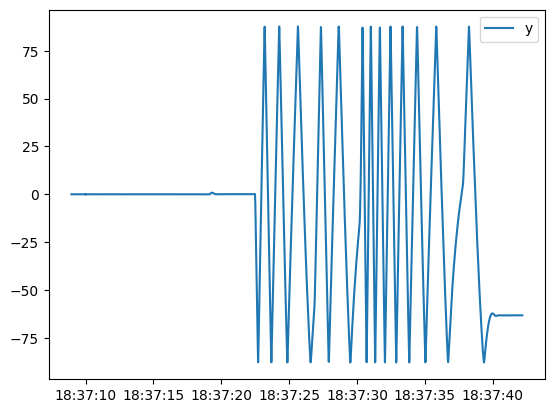

In [15]:
plt.plot(_m_df["time"], _theta_y, label="y")
plt.legend()

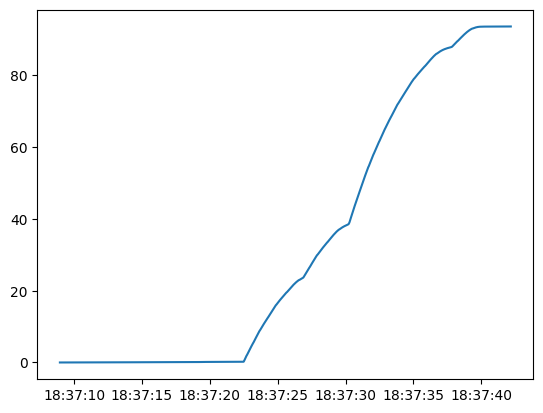

In [16]:
theta_df = pd.DataFrame({"time": _m_df["time"], "theta_y": _theta_y})
theta_df["diff"] = abs(theta_df["theta_y"].diff())
# replace nan with 0
theta_df["diff"].fillna(0, inplace=True)
# integrate angle
df, _ = get_orientation(theta_df, "diff")
plt.plot(df["time"], df["theta"], label="y")

In [24]:
"""plot the angle from skateboard and mocap"""
# plt.plot(_new_ang_df["time"], _new_ang_df["theta"], label="sk")
# plt.plot(df["time"], df["theta"], label="mc")

'plot the angle from skateboard and mocap'